In [1]:
# Set paths
idmap_train_dir = '../../data/input/trainmap.csv'
methy_train_dir = '../../data/input/traindata.csv'
idmap_test_dir = '../../data/input/testmap.csv'
methy_test_dir = '../../data/input/testdata.csv'
indices_levine_dir = '../../data/output/indices_list.pkl'
indices_hovarth_dir = '../../data/output/indices_list_horvath.pkl'
output_dir = "../data/output/"

In [2]:
import pandas as pd
import h5py

# Save data as HDF5 files
def save_file_h5(methy_dir, chunk_size, name):
    df_chunks = pd.read_csv(methy_dir,
                            sep=',',
                            index_col=0,
                            chunksize=chunk_size)

    with h5py.File(name, 'w') as file:
        total_cols = 0
        for i, chunk in enumerate(df_chunks):
            chunk = chunk.transpose()
            chunk = chunk.fillna(0)
            data_array = chunk.to_numpy()
            chunk_cols = data_array.shape[1]
            if i == 0:
                samples_num = data_array.shape[0]
                dataset = file.create_dataset('data',
                                              shape=data_array.shape,
                                              maxshape=(samples_num, None))

            dataset.resize((dataset.shape[0], total_cols + chunk_cols))
            dataset[:, total_cols:total_cols + chunk_cols] = data_array
            total_cols += chunk_cols

    return None

In [3]:
create_h5 = False

# Save data
if create_h5:
    chunk_size = 5000

    save_file_h5(methy_train_dir, chunk_size, output_dir + 'train.h5')
    print('Train data saved.')

    save_file_h5(methy_test_dir, chunk_size, output_dir + 'test.h5')
    print('Test data saved.')

In [4]:
import numpy as np

# Load idmap data from .csv file
def load_idmap_csv(file):
    sample_type_mapping = {'control': 0, 'disease tissue': 1}
    
    idmap = pd.read_csv(file, sep=',')
    age = idmap.age.to_numpy()
    age = age.astype(np.float32)
    sample_type = idmap.sample_type.replace(sample_type_mapping)
    
    return age, sample_type

# Load methylation data from .h5 file.
def load_methylation_h5(file, rows=None, extra=None):
    with h5py.File(file, 'r') as h5file:
        methylation = h5file['data'][:]
    
    if rows is not None:
        if isinstance(rows, int):
            methylation = methylation[:, :rows]
        elif isinstance(rows, list):
            if extra is not None:
                extra_data = methylation[:, :extra]
                specific_data = methylation[:, rows]
                methylation = np.hstack((extra_data, specific_data))
            else:
                methylation = methylation[:, rows]
        else:
            return methylation[:, :]
        
    return methylation

In [5]:
import pickle

# Load idmap
age, sample_type = load_idmap_csv(idmap_train_dir)
print("ID map loaded.")

age_train = age[:5000]
age_test = age[5000:]

print("age_train shape:", age_train.shape)
print("age_test shape:",age_test.shape)

sample_train = sample_type[:5000]
sample_test = sample_type[5000:]

print("sample_train shape:", sample_train.shape)
print("sample_test shape:",sample_test.shape)

# Load methylation data
# with open(indices_levine_dir, 'rb') as indices_levine_file:
#     indices_levine = pickle.load(indices_levine_file)

with open(indices_hovarth_dir, 'rb') as indices_hovarth_file:
    indices_hovarth = pickle.load(indices_hovarth_file)

# optimal_indices = indices_levine + indices_hovarth
# optimal_indices = sorted(set(optimal_indices))

methylation_data = load_methylation_h5('../../data/input/train.h5', rows=indices_hovarth)
print("\nMethylation data loaded.")

train_data = methylation_data[:5000]
test_data = methylation_data[5000:]

print("methylation_train shape:", train_data.shape)
print("methylation_test shape:", test_data.shape)

ID map loaded.
age_train shape: (5000,)
age_test shape: (3233,)
sample_train shape: (5000,)
sample_test shape: (3233,)

Methylation data loaded.
methylation_train shape: (5000, 353)
methylation_test shape: (3233, 353)


In [6]:
from sklearn.model_selection import train_test_split
import random

random.seed(42)

# Split data into training and validation sets
indices = np.arange(sample_train.shape[0])
[indices_train, indices_valid, age_train, age_valid] = train_test_split(indices, age_train, test_size=0.15, shuffle=True)

methylation_train = train_data[indices_train]
methylation_valid = train_data[indices_valid]

sample_type_train = sample_train[indices_train]
sample_type_valid = sample_train[indices_valid]

feature_size = methylation_train.shape[1]


In [7]:
from sklearn.svm import NuSVR
from sklearn.model_selection import GridSearchCV

# Train NuSVR model
def train_ml(X_train, y_train):
    # Define the parameter grid
    param_grid = {'nu': [0.1, 0.5, 0.9], 'C': [0.1, 1, 10], 'kernel': ['rbf'], 'gamma': ['scale', 'auto', 0.1, 0.01]}

    # Create a NuSVR regressor
    nu_svr_regressor = NuSVR()

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(nu_svr_regressor, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_

    # Train the model with the best parameters
    best_nu_svr_regressor = NuSVR(**best_params)
    best_nu_svr_regressor.fit(X_train, y_train)

    return best_nu_svr_regressor


# Evaluate model
def evaluate_ml(mode, y_true, y_pred, sample_type):
    if mode == 'MAE':
        mae_control = np.mean(np.abs(y_true[sample_type == 0] - y_pred[sample_type == 0]))

        case_true = y_true[sample_type == 1]
        case_pred = y_pred[sample_type == 1]
        above = np.where(case_pred >= case_true)
        below = np.where(case_pred < case_true)

        ae_above = np.sum(np.abs(case_true[above] - case_pred[above])) / 2
        ae_below = np.sum(np.abs(case_true[below] - case_pred[below]))
        mae_case = (ae_above + ae_below) / len(case_true)

        mae = np.mean([mae_control, mae_case])
        return mae, mae_control, mae_case


In [8]:
import time
from sklearn.metrics import r2_score

# Train new model
train_model = True

# Model path
model = '../../data/output/svr.pkl'

if train_model:
    # Train data
    print('Training started.')
    start = time.time()
    pred_model = train_ml(methylation_train, age_train)
    print(f'Training time: {time.time() - start}s')

    # Save model to pkl
    model_filename = "../../data/output/svr.pkl"
    with open(model_filename, 'wb') as model_file:
        pickle.dump(pred_model, model_file)
    print(f'Model saved to {model_filename}')
else:
    # Load model
    with open(model, 'rb') as model_file:
        pred_model = pickle.load(model_file)
    print(f'{model} loaded.')

# Evaluate model
evaluation_mode = 'MAE'

age_valid_pred = pred_model.predict(methylation_valid)
age_valid_eval = evaluate_ml(evaluation_mode, age_valid, age_valid_pred, sample_type_valid)
print(f'Validation {evaluation_mode}: {age_valid_eval}')

age_test_pred = pred_model.predict(test_data)
age_test_eval = evaluate_ml(evaluation_mode, age_test, age_test_pred, sample_test)
print(f'Test {evaluation_mode}: {age_test_eval}')

# Calculate R^2 values
r2_valid = r2_score(age_valid, age_valid_pred)
r2_test = r2_score(age_test, age_test_pred)

print(f'Validation R^2: {r2_valid}')
print(f'Test R^2: {r2_test}')

# Post-processing to ensure age >= 0
age_valid_pred[age_valid_pred < 0] = 0  
age_test_pred[age_test_pred < 0] = 0  


Training started.
Training time: 266.14522910118103s
Model saved to ../../data/output/svr.pkl
Validation MAE: (3.427524548929337, 3.951395574986161, 2.903653522872513)
Test MAE: (4.306882437855958, 4.5108887339490416, 4.102876141762874)
Validation R^2: 0.9489328217374242
Test R^2: 0.8786057855822257


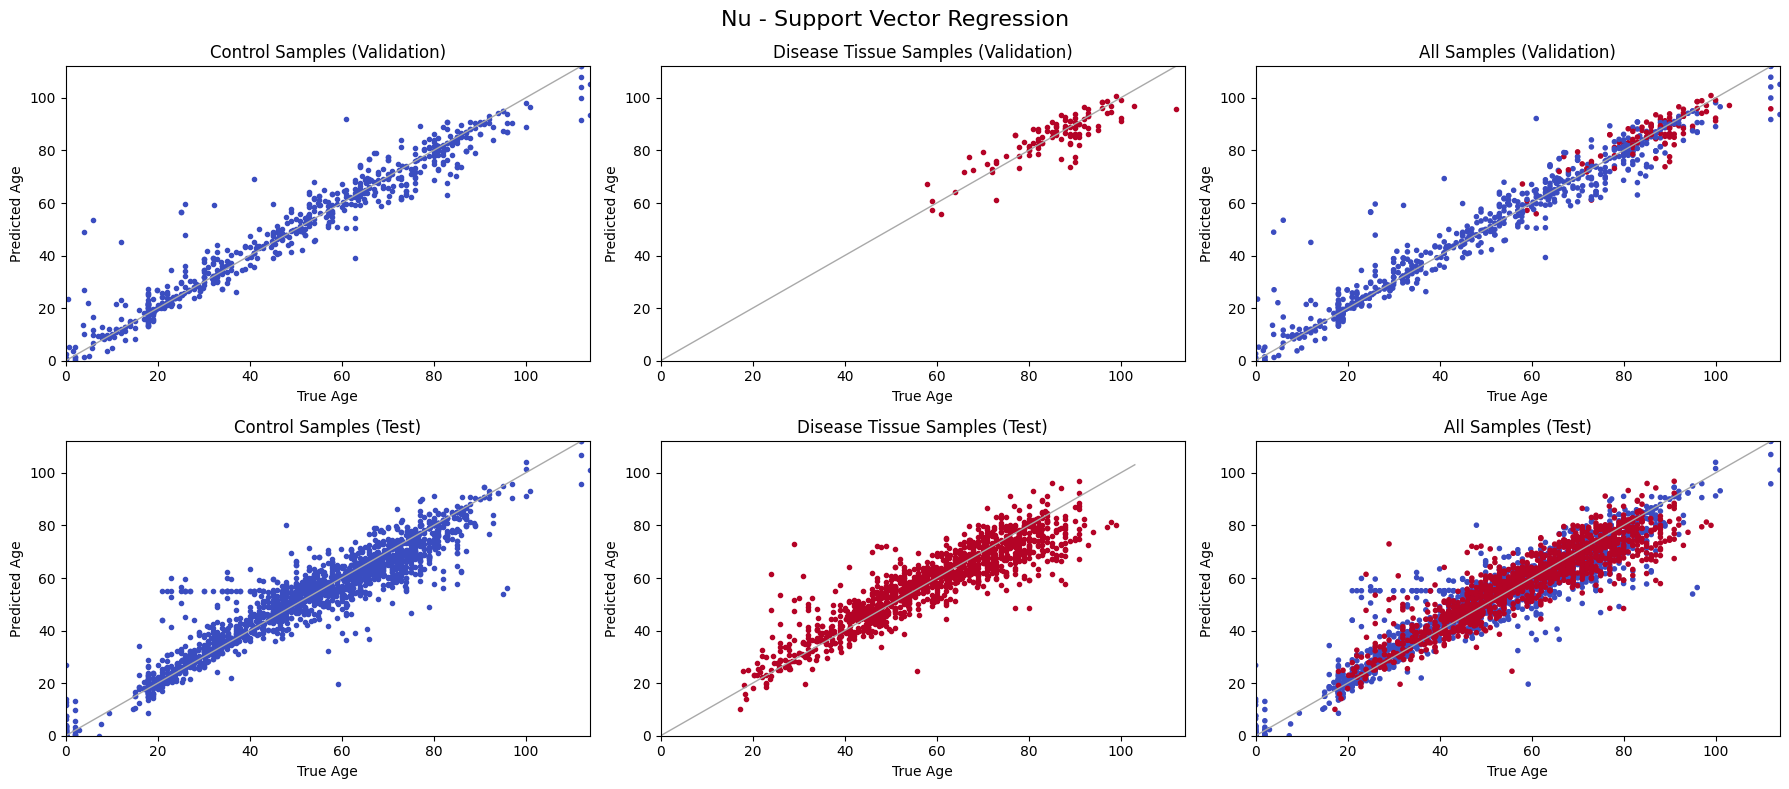

In [9]:
import matplotlib.pyplot as plt

# Separate data for control and disease tissue samples in the validation set
control_valid_mask = sample_type_valid == 0
disease_valid_mask = sample_type_valid == 1

# Separate data for control and disease tissue samples in the test set
control_test_mask = sample_test == 0
disease_test_mask = sample_test == 1

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Set title
plt.suptitle("Nu - Support Vector Regression", fontsize=16)

# Prediction line
def plot_perfect_prediction_line(ax):
    x = ax.get_xlim()
    y = ax.get_ylim()
    min_val = 0
    max_val = max(x[1], y[1])
    ax.plot([min_val, max_val], [min_val, max_val], '-', color='darkgray', linewidth=1.0)

# Plot the graphs for the validation set
axes[0, 0].scatter(age_valid[control_valid_mask], age_valid_pred[control_valid_mask], marker='.', c='#3a4dc0')
plot_perfect_prediction_line(axes[0, 0])
axes[0, 0].set_xlim(left=min(age_valid), right=max(age_valid))
axes[0, 0].set_ylim(bottom=min(age_valid_pred), top=max(age_valid_pred))
axes[0, 0].set_xlabel('True Age')
axes[0, 0].set_ylabel('Predicted Age')
axes[0, 0].set_title('Control Samples (Validation)')

axes[0, 1].scatter(age_valid[disease_valid_mask], age_valid_pred[disease_valid_mask], marker='.', c='#b40326')
plot_perfect_prediction_line(axes[0, 1])
axes[0, 1].set_xlim(left=min(age_valid), right=max(age_valid))
axes[0, 1].set_ylim(bottom=min(age_valid_pred), top=max(age_valid_pred))
axes[0, 1].set_xlabel('True Age')
axes[0, 1].set_ylabel('Predicted Age')
axes[0, 1].set_title('Disease Tissue Samples (Validation)')

axes[0, 2].scatter(age_valid, age_valid_pred, marker='.', c=sample_type_valid, cmap=plt.cm.coolwarm)
plot_perfect_prediction_line(axes[0, 2])
axes[0, 2].set_xlim(left=min(age_valid), right=max(age_valid))
axes[0, 2].set_ylim(bottom=min(age_valid_pred), top=max(age_valid_pred))
axes[0, 2].set_xlabel('True Age')
axes[0, 2].set_ylabel('Predicted Age')
axes[0, 2].set_title('All Samples (Validation)')

# Plot the graphs for the test set
axes[1, 0].scatter(age_test[control_test_mask], age_test_pred[control_test_mask], marker='.', c='#3a4dc0')
plot_perfect_prediction_line(axes[1, 0])
axes[1, 0].set_xlim(left=min(age_test), right=max(age_test))
axes[1, 0].set_ylim(bottom=min(age_test_pred), top=max(age_test_pred))
axes[1, 0].set_xlabel('True Age')
axes[1, 0].set_ylabel('Predicted Age')
axes[1, 0].set_title('Control Samples (Test)')

axes[1, 1].scatter(age_test[disease_test_mask], age_test_pred[disease_test_mask], marker='.', c='#b40326')
plot_perfect_prediction_line(axes[1, 1])
axes[1, 1].set_xlim(left=min(age_test), right=max(age_test))
axes[1, 1].set_ylim(bottom=min(age_test_pred), top=max(age_test_pred))
axes[1, 1].set_xlabel('True Age')
axes[1, 1].set_ylabel('Predicted Age')
axes[1, 1].set_title('Disease Tissue Samples (Test)')

axes[1, 2].scatter(age_test, age_test_pred, marker='.', c=sample_test, cmap=plt.cm.coolwarm)
plot_perfect_prediction_line(axes[1, 2])
axes[1, 2].set_xlim(left=min(age_test), right=max(age_test))
axes[1, 2].set_ylim(bottom=min(age_test_pred), top=max(age_test_pred))
axes[1, 2].set_xlabel('True Age')
axes[1, 2].set_ylabel('Predicted Age')
axes[1, 2].set_title('All Samples (Test)')

plt.tight_layout()
plt.show()

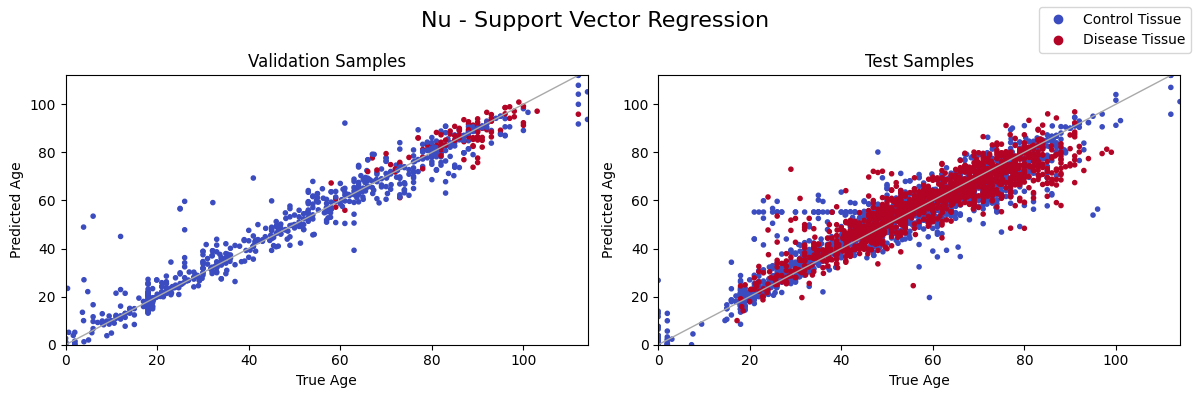

In [10]:
import matplotlib.pyplot as plt

# Separate data for control and disease tissue samples in the validation set
control_valid_mask = sample_type_valid == 0
disease_valid_mask = sample_type_valid == 1

# Separate data for control and disease tissue samples in the test set
control_test_mask = sample_test == 0
disease_test_mask = sample_test == 1

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Set title
plt.suptitle("Nu - Support Vector Regression", fontsize=16)

# Prediction line
def plot_perfect_prediction_line(ax):
    x = ax.get_xlim()
    y = ax.get_ylim()
    min_val = 0
    max_val = max(x[1], y[1])
    ax.plot([min_val, max_val], [min_val, max_val], '-', color='darkgray', linewidth=1.0)

# Plot control and disease samples with a legend
for i, ax in enumerate(axes):
    if i == 0:
        scatter = ax.scatter(age_valid, age_valid_pred, marker='.', c=sample_type_valid, cmap=plt.cm.coolwarm)
    else:
        scatter = ax.scatter(age_test, age_test_pred, marker='.', c=sample_test, cmap=plt.cm.coolwarm)

    plot_perfect_prediction_line(ax)
    ax.set_xlim(left=min(age_valid), right=max(age_valid))
    ax.set_ylim(bottom=min(age_valid_pred), top=max(age_valid_pred))
    ax.set_xlabel('True Age')
    ax.set_ylabel('Predicted Age')
    ax.set_title('Validation Samples' if i == 0 else 'Test Samples')

# Create a legend
legend_labels = ['Control Tissue', 'Disease Tissue']
legend = fig.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc="upper right")

plt.tight_layout()
plt.show()
